In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

#그래프의 마이너스(-) 폰트 깨짐 해결
mpl.rcParams['axes.unicode_minus'] = False
#그래프의 한글 깨짐 해결
plt.rc('font', family='Malgun Gothic')


df1 = pd.read_csv('COVID-19.csv', encoding='cp949')
df2 = pd.read_csv('Moving_People.csv', encoding='cp949')
df3 = pd.read_csv('report.csv', encoding='utf-8')

#------서울 코로나 확진자 수 데이터 전처리-------
df1.drop(['연번','접촉력','환자번호','국적','환자정보','여행력','조치사항','상태','이동경로',
          '등록일','수정일','노출여부'], axis = 'columns', inplace = True) #필요 없는 데이터 삭제
df1['확진일']=df1['확진일'].str.replace(".","") #확진일 형식 통일(ex.20201205)
df1['확진일']="2020"+df1['확진일']
indexNames = df1[(df1['확진일'] > '20201205')].index #데이터 형식 통일
df1.drop(indexNames, inplace = True)
df1['확진일'] = df1['확진일'].astype(int)

#-------서울 유동인구 수 데이터 전처리-----------
df2.drop(['시군구코드','내국인생활인구수','장기체류외국인인구수','단기체류외국인인구수','일최대인구수',
          '일최소인구수','주간인구수(09~18)','야간인구수(19~08)','일최대이동인구수','서울외유입인구수',
          '총생활인구수'],axis = 'columns', inplace = True) #필요 없는 데이터 삭제
indexNames = df2[(df2['기준일ID'] >=20180405 )
                 & (df2['기준일ID'] <20200124)].index #코로나 첫 확진자 발생 시기
df2.drop(indexNames, inplace = True)
indexNames = df2[(df2['기준일ID'] > 20201205)].index
df2.drop(indexNames, inplace = True) #데이터 형식 통일
pd.options.display.float_format = '{:.4f}'.format #소수점 4째자리까지 나오게 설정
df2['유동인구'] = df2.loc[:,['동일자치구행정동간이동인구수','자치구간이동인구수']].sum(axis=1) #유동인구
df2.drop(['동일자치구행정동간이동인구수','자치구간이동인구수'],axis = 'columns', inplace = True)

#-------서울 주민등록 인구 수 데이터 전처리-----------
df3.drop(['세대','남자 합계','여자 합계','한국인 합계','한국 남자','한국 여자', '외국인 합계','외국인 남자',
          '외국인 여자','세대당인구','65세이상고령자'], axis = 'columns', inplace= True) #필요 없는 데이터 삭제

#----------새로운 colunm, index---------
area = [] #colunm 설정
area = df2['시군구명'].to_numpy(copy=True)
area = area[0:26]

day = [] #index 설정
day1 = df2['기준일ID'].to_numpy(copy=True)
for i in range(0,8242,26):
    day.append(day1[i])

     
#----------확진자 수---------------
covid_people = pd.DataFrame(index = day, columns = area) #인덱스가 20200124~20201205, 열 이름이 서울 지역(서울시 포함)
for i in range(26):
    for k in range(317):
        people_num = len(df1[df1['지역'].isin([area[i]]) & df1['확진일'].isin([day[k]])]) #
        covid_people.iloc[[k],[i]] = people_num
        covid_people.iloc[[k], 0] +=people_num
        
#————유동 인구 수————————
moving_people = pd.DataFrame(index = day, columns = area) #인덱스가 20200124~20201205, 열 이름이 서울 지역(서울시 포함)
for i in range(26):
    a = df2[df2['시군구명'].isin([area[i]])]
    data = a['유동인구'].to_numpy(copy=True)
    moving_people.loc[:,area[i]] = data

#————주민등록 인구 수——————
num = df3['합계'].to_numpy(copy=True) #인덱스가 2020년 분기(1분기 ~ 3분기), 열 이름이 서울 지역(서울시 포함)
num3 = num[0:26]
num2 = num[26:52]
num1 = num[52:]

df_people = pd.DataFrame(index = ['2020.3/4', '2020.2/4','2020.1/4'],columns = area)
df_people.iloc[0] = num3
df_people.iloc[1] = num2
df_people.iloc[2] = num1

#------서울 코로나 확진자(월별)------
month = [] * 12 #월의 개수
for i in range(12):
    month.append(i+1)

covid_people_Month = pd.DataFrame(index = month,columns = area) #서울 자치구 코로나 확진자 수(월별) 데이터프레임

j = 0
k = -1
while True: #while문의 무한루프를 이용해 월마다 다른 일 수를 고려하여 데이터 저장
    month1 = day[j]//100
    k += 1
    if month1-202000 < 8: #7월부터는 짝수가 31일
        if month1%2 == 0:
            if month1 == 202002: #2월일때
                covid_people_Month.loc[12-k] = covid_people.iloc[j:j+29,:].sum()
                j += 29
                continue #다음 반복 이동
            covid_people_Month.loc[12-k] = covid_people.iloc[j:j+30,:].sum()
            j += 30  
        else:
            if month1 == 202001: #1월일때
                covid_people_Month.loc[12-k] = covid_people.iloc[j:j+8,:].sum()
                j += 8 #코로나 첫 확진자 발생일에 따른 데이터 개수
                break #반복문 탈출
            covid_people_Month.loc[12-k] = covid_people.iloc[j:j+31,:].sum()
            j += 31
    else:
        if month1%2 == 0:
            if month1 == 202012: #12월일때
                covid_people_Month.loc[12-k] = covid_people.iloc[j:j+5,:].sum()
                j += 5 #보유하고 있는 12월 데이터가 5개
                continue #다음 반복 이동
            covid_people_Month.loc[12-k] = covid_people.iloc[j:j+31,:].sum()
            j += 31  
        else:
            covid_people_Month.loc[12-k] = covid_people.iloc[j:j+30,:].sum()
            j += 30
        
covid_people_Month = covid_people_Month.astype(int)

#-------유동인구 수(월별)-------
moving_people_Month = pd.DataFrame(index = month,columns = area) #서울 자치구 유동인구 수(월별) 데이터프레임

j = 0
k = -1
while True: #while문의 무한루프를 이용해 월마다 다른 일 수를 고려하여 데이터 저장
    month1 = day[j]//100 
    k += 1
    if month1-202000 < 8: #7월부터는 짝수가 31일
        if month1%2 == 0:
            if month1 == 202002: #2월일때
                moving_people_Month.loc[12-k] = moving_people.iloc[j:j+29,:].sum()
                j += 29
                continue #다음 반복 이동
            moving_people_Month.loc[12-k] = moving_people.iloc[j:j+30,:].sum()
            j += 30  
        else:
            if month1 == 202001: #1월일때
                moving_people_Month.loc[12-k] = moving_people.iloc[j:j+8,:].sum()
                j += 8 #코로나 첫 확진자 발생일에 따른 데이터 개수
                break #반복문 탈출
            moving_people_Month.loc[12-k] = moving_people.iloc[j:j+31,:].sum()
            j += 31
    else:
        if month1%2 == 0:
            if month1 == 202012: #12월일때
                moving_people_Month.loc[12-k] = moving_people.iloc[j:j+5,:].sum()
                j += 5 #보유하고 있는 12월 데이터가 5개
                continue #다음 반복 이동
            moving_people_Month.loc[12-k] = moving_people.iloc[j:j+31,:].sum()
            j += 31  
        else:
            moving_people_Month.loc[12-k] = moving_people.iloc[j:j+30,:].sum()
            j += 30
        
#---------확진자 비율(월별)------------
covid_Month = pd.DataFrame(index = month, columns = area) 
#분기별 주민등록 인구 수 이용
covid_Month.iloc[0:3] = covid_people_Month.iloc[0:3] / df_people.iloc[0]
covid_Month.iloc[3:6] = covid_people_Month.iloc[3:6] / df_people.iloc[1]
covid_Month.iloc[6:] = covid_people_Month.iloc[6:] / df_people.iloc[2]

#---------유동인구 비율(월별)---------
moving_Month = pd.DataFrame(index = month,columns = area)
#분기별 주민등록 인구 수 이용
moving_Month.iloc[0:3] = moving_people_Month.iloc[0:3] / df_people.iloc[0]
moving_Month.iloc[3:6] = moving_people_Month.iloc[3:6] / df_people.iloc[1]
moving_Month.iloc[6:] = moving_people_Month.iloc[6:] / df_people.iloc[2]

#---------유동인구 비율 % (일별)--------
moving_Day = pd.DataFrame(index = day, columns = area)
#분기별 주민등록 인구 수 이용
moving_Day.iloc[0:158] = ((moving_people.iloc[0:158] / df_people.iloc[2])*100)
moving_Day.iloc[158:249] = ((moving_people.iloc[158:249] / df_people.iloc[1])*100)
moving_Day.iloc[249:317] = ((moving_people.iloc[249:317] / df_people.iloc[0])*100)


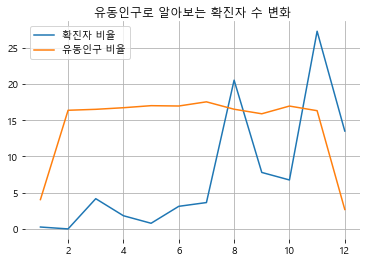

달을 입력하세요: 4


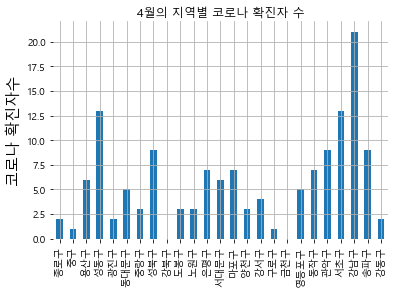

지역을 입력하세요: 중구


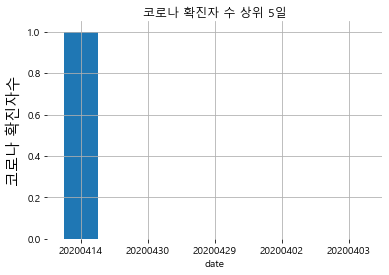



기준일의 전날과 다음날의 유동인구 비율


,전날,다음날
date,,
20200414,97.9815,182.0544


In [3]:
#----------------첫 화면------------------
covid_seoul = pd.DataFrame(index = ["확진자 비율", "유동인구 비율"], columns = month)
covid_seoul.iloc[0, :] = covid_Month.iloc[:,14]*100000
covid_seoul.iloc[1, :] = moving_Month.iloc[:, 14]
covid_seoul.T.plot(title= '유동인구로 알아보는 확진자 수 변화') #선 그래프 생성
plt.grid()
plt.box(False)
plt.show()

#------------메뉴 1번 - 월 검색-----------------
m =  int(input("달을 입력하세요: "))
covid_m = pd.DataFrame(index = area[1:], columns = [m])
covid_m.iloc[:,0] = covid_people_Month.iloc[m-1, 1:] #입력받은 값에 맞는 데이터 저장
covid_m.iloc[:,0].T.plot(kind = 'bar',title= str(m)+'월의 지역별 코로나 확진자 수',rot=90) #막대 그래프 생성
plt.ylabel('코로나 확진자수', fontsize = 15)
plt.grid()
plt.box(False)
plt.show()


#------------메뉴 1번 - 지역 검색---------------
a =  input("지역을 입력하세요: ")
m = (202000 + m)*100
covid = covid_people.reset_index() #일별 데이터의 날짜를 입력받은 달과 비교하기 위해 인덱스 재설정
covid.rename(columns = {"index":"date"}, inplace = True) #원래의 인덱스를 "date" 컬럼으로 설정
covid = covid[np.logical_and(m<covid['date'], covid['date'] < m+100)] #같은 달 데이터 추출
covid.set_index('date', inplace=True) #인덱스 원래대로 재설정
covid = covid.sort_values(by=[a], axis= 0, ascending= False).head() #입력한 지역의 데이터 정렬 후 상위 5개 추출
covid.loc[:,a].T.plot(kind = 'bar',title= '코로나 확진자 수 상위 5일', rot=0) #막대 그래프 생성
plt.ylabel('코로나 확진자수', fontsize = 15)
plt.grid()
plt.box(False)
plt.show()


top_date = covid.index # 상위 5개의 날짜 저장
idx = [] #day배열에서의 날짜 index 변수
id = 0 #area배열에서의 지역 index 변수
for i in range(len(area)): #입력한 지역과 동일한 지역 찾기
    if a == area[i]:
        id = i
for i in range(len(top_date)): #출력한 상위 5개의 날짜와 동일한 날짜 찾기
    for j in range(len(day)):
        if top_date[i] == day[j]:
            if covid_people.loc[day[j],a]!=0: #확진자 수가 0명이 아닐때만 데이터 저장
                idx.append(j)     

                
top_moving = pd.DataFrame(index = top_date[:len(idx)], columns = ['전날', '다음날'])
#상위 5개 날짜의 전날과 다음날 거리두기 실행 안된 백분율(유동인구 백분율)
for i in range(len(idx)): #확진자 수 0명인 날을 제외하고 출력
    m = idx[i] -1
    n = idx[i] +1
    top_moving.iloc[i, 0] = moving_Day.iloc[m,id]
    top_moving.iloc[i, 1] = moving_Day.iloc[n,id]
print("\n\n기준일의 전날과 다음날의 유동인구 비율")
top_moving

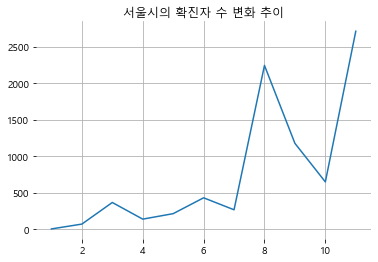

 < 거리두기 단계 변화 >
① 3/22 : 고강도 거리두기 단계
② 5/6 : 생활 속 거리두기 단계
③ 6/24 : 단계적 거리두기 도입 : 1단계
④ 8/16 : 2단계 격상
⑤ 9/4 : 2.5단계 격상
⑥ 10/11 : 1단계 격하
⑦ 11/19 : 1.5단계 격상 (11/7 : 5단계 거리두기 세분화)
⑧ 11/24 : 2단계 격상

사람들의 거리두기 실행을 알고싶은 거리두기 단계 변화 > 4
④ 8/16 : 2단계 격상


서울시의 거리두기 단계 변화일의 전후 일주일간의 유동인구 비율 평균


,이전 7일간 평균,이후 7일간 평균
서울시,42.5488,44.9666


In [4]:
#-----------메뉴 2번-----------
c = covid_people_Month.loc[:,'서울시'] #서울시 확진자 수(월별)
c = c.drop([12]) #12월은 제외
c.T.plot(title= '서울시의 확진자 수 변화 추이', rot=0) #선 그래프 생성
plt.grid()
plt.box(False)
plt.show()

step = ['① 3/22 : 고강도 거리두기 단계','② 5/6 : 생활 속 거리두기 단계',
        '③ 6/24 : 단계적 거리두기 도입 : 1단계','④ 8/16 : 2단계 격상',
        '⑤ 9/4 : 2.5단계 격상', '⑥ 10/11 : 1단계 격하',
        '⑦ 11/19 : 1.5단계 격상 (11/7 : 5단계 거리두기 세분화)','⑧ 11/24 : 2단계 격상']
step_day = [20200322, 20200506, 20200624, 20200816, #거리두기 변화 시점
           20200904, 20201011, 20201119, 20201124 ]
day_idx = [258,213,164,111,92,55,16,11] #day 배열에서의 거리두기 변화 시점 index

print(' < 거리두기 단계 변화 >')
for i in range (8):
    print(step[i])

print('')

step_num = int(input('사람들의 거리두기 실행을 알고싶은 거리두기 단계 변화 > '))
step_num = step_num-1 #index값으로 변경

x = day_idx[step_num] - 7 #기준날에서 7일 전
y = day_idx[step_num] + 1#기준날에서 1일 후

avg_before = 0 #기준날 이전 7일간 평균
avg_after = 0 #기준날 이후 7일간 평균

#선택된 거리두기 단계 변화 날짜의 이전 7일간과 이후 7일간 거리두기 실행 안된 비율 평균(유동인구 비율 평균)
df_level = pd.DataFrame(index = ['서울시'], columns = ['이전 7일간 평균', '이후 7일간 평균'])
for i in range(7): #7일동안의 값의 합
    avg_before += moving_Day.iloc[x,0]
    avg_after += moving_Day.iloc[y,0]
    x += 1
    y += 1

df_level.iloc[0,0] = avg_before/7
df_level.iloc[0,1] = avg_after/7

print(step[step_num])
print("\n\n서울시의 거리두기 단계 변화일의 전후 일주일간의 유동인구 비율 평균")
df_level